In [1]:
from functions import * # importing our own functions defined in functions.py

import matplotlib.pyplot as plt
plt.style.use(['classic'])
plt.rcParams['figure.facecolor'] = 'white'

/Users/sheilaalemany/miniforge3/envs/m1ai/lib/python3.9/site-packages/art/estimators/certification/__init__.py:13: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


For our evaluation, we are using the Adversarial Robustness Toolbox found [here](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/).

# Importing MNIST

In [2]:
from art.utils import load_dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("mnist"))

In [3]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


# Training Classifiers

## Generalized Gamma

In [4]:
@tf.custom_gradient
def gamma_activation(x):
    def grad(dy):
        return gamma_derivative(x) * dy

    result = generalized_gamma(x)
    return result, grad

In [5]:
model = define_model(gamma_activation)
classifier = train_model(model, x_train, y_train, x_test, y_test, eps=15, clip_values=(min_, max_))

...created classifier
Before training time (EST):  2023-05-16 17:21:42.774193-05:00
...finished training
Time after training finished:  2023-05-16 17:30:00.289167-05:00
Test accuracy: 92.35%



In [6]:
eval_x_test, eval_y_test = get_successful_test(classifier, x_test, y_test)

Original test accuracy: 92.35%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## ReLU

In [7]:
model_relu = define_model(tf.nn.relu)
classifier_relu = train_model(model_relu, x_train, y_train, x_test, y_test, eps=10, clip_values=(min_, max_))

...created classifier
Before training time (EST):  2023-05-16 17:30:04.044976-05:00
...finished training
Time after training finished:  2023-05-16 17:32:28.608512-05:00
Test accuracy: 98.04%



In [8]:
eval_x_test_relu, eval_y_test_relu = get_successful_test(classifier_relu, x_test, y_test)

Original test accuracy: 98.04%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## Tanh

In [10]:
model_tanh = define_model(tf.nn.tanh)
classifier_tanh = train_model(model_tanh, x_train, y_train, x_test, y_test, eps=10)

...created classifier
Before training time (EST):  2023-05-16 17:32:51.511808-05:00
...finished training
Time after training finished:  2023-05-16 17:35:18.043478-05:00
Test accuracy: 96.75%



In [11]:
eval_x_test_tanh, eval_y_test_tanh = get_successful_test(classifier_tanh, x_test, y_test)

Original test accuracy: 96.75%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## Swish

In [12]:
model_swish = define_model(tf.keras.activations.swish)
classifier_swish = train_model(model_swish, x_train, y_train, x_test, y_test, eps=10)

...created classifier
Before training time (EST):  2023-05-16 17:35:19.603654-05:00
...finished training
Time after training finished:  2023-05-16 17:38:14.459313-05:00
Test accuracy: 97.83%



In [13]:
eval_x_test_swish, eval_y_test_swish = get_successful_test(classifier_swish, x_test, y_test)

Original test accuracy: 97.83%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## Tent Activation

In [19]:
# @tf.custom_gradient
# def tent_activation_func(x):
#     def grad(dy):
#         return tent_derivative(x)*dy

#     result = tent_activation(x)
#     return result, grad

In [ ]:
# model_tent = define_model(tent_activation_func)
# classifier_tent = train_model(model_tent, x_train, y_train, x_test, y_test, eps=25, filename='tent')

In [20]:
# eval_x_test_tent, eval_y_test_tent = get_successful_test(classifier_tent, x_test, y_test)

# Evaluate with Adversarial Training

In [16]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import KerasClassifier
from art.data_generators import KerasDataGenerator
from art.defences.trainer import AdversarialTrainer

def doing_adversarial_training(model, classifier, x_train, x_test, y_train, y_test, epochs=10):
    # Craft adversarial samples PGD
    adv_crafter = ProjectedGradientDescent(classifier)
    x_train_adv = adv_crafter.generate(x_train)
    x_test_adv = adv_crafter.generate(x_test)
    print('...adversarial examples generated successfully')
    print(x_train_adv.shape, x_test_adv.shape)
    
    # Evaluate the classifier on the adversarial samples
    preds = np.argmax(classifier.predict(x_test_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("Accuracy on adversarial samples (before adversarial training): ", (acc * 100))

    # Data augmentation: expand the training set with the adversarial samples
    x_train = np.append(x_train, x_train_adv, axis=0)
    y_train = np.append(y_train, y_train, axis=0)
    print('Verify new shapes: ', x_train.shape, y_train.shape)
    
    # Retrain the CNN on the extended dataset
    classifier_new = train_model(model, x_train, y_train, x_test, y_test, eps=epochs)
    
    # Evaluate the adversarially trained classifier on the test set
    preds = np.argmax(classifier_new.predict(x_test_adv), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    # logger.info("Classifier with adversarial training")
    print("Accuracy on adversarial samples (after adversarial training): ", (acc * 100))
    
    return classifier_new

In [17]:
classifier_gengamma_new = doing_adversarial_training(model, classifier, x_train, x_test, y_train, y_test, epochs=15)

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

...adversarial examples generated successfully
(60000, 28, 28, 1) (10000, 28, 28, 1)
Accuracy on adversarial samples (before adversarial training):  3.45
Verify new shapes:  (120000, 28, 28, 1) (120000, 10)
...created classifier
Before training time (EST):  2023-05-16 21:50:59.280708-05:00
...finished training
Time after training finished:  2023-05-16 22:02:05.487008-05:00
Test accuracy: 98.19%

Accuracy on adversarial samples (after adversarial training):  97.45


In [33]:
eval_x_test_new, eval_y_test_new = get_successful_test(classifier_gengamma_new, x_test, y_test)

Original test accuracy: 98.19%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


In [18]:
classifier_relu_new = doing_adversarial_training(model_relu, classifier_relu, x_train, x_test, y_train, y_test, epochs=10)

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

...adversarial examples generated successfully
(60000, 28, 28, 1) (10000, 28, 28, 1)
Accuracy on adversarial samples (before adversarial training):  1.32
Verify new shapes:  (120000, 28, 28, 1) (120000, 10)
...created classifier
Before training time (EST):  2023-05-16 23:20:52.032277-05:00
...finished training
Time after training finished:  2023-05-16 23:25:51.720298-05:00
Test accuracy: 97.85%

Accuracy on adversarial samples (after adversarial training):  97.38


In [32]:
eval_x_test_relu_new, eval_y_test_relu_new = get_successful_test(classifier_relu_new, x_test, y_test)

Original test accuracy: 97.85%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


In [19]:
classifier_tanh_new = doing_adversarial_training(model_tanh, classifier_tanh, x_train, x_test, y_train, y_test, epochs=10)

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

...adversarial examples generated successfully
(60000, 28, 28, 1) (10000, 28, 28, 1)
Accuracy on adversarial samples (before adversarial training):  1.51
Verify new shapes:  (120000, 28, 28, 1) (120000, 10)
...created classifier
Before training time (EST):  2023-05-17 00:46:33.193859-05:00
...finished training
Time after training finished:  2023-05-17 00:51:34.733561-05:00
Test accuracy: 97.92%

Accuracy on adversarial samples (after adversarial training):  96.72


In [34]:
eval_x_test_tanh_new, eval_y_test_tanh_new = get_successful_test(classifier_tanh_new, x_test, y_test)

Original test accuracy: 97.92%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


In [20]:
classifier_swish_new = doing_adversarial_training(model_swish, classifier_swish, x_train, x_test, y_train, y_test, epochs=10)

PGD - Batches: 0it [00:00, ?it/s]

PGD - Batches: 0it [00:00, ?it/s]

...adversarial examples generated successfully
(60000, 28, 28, 1) (10000, 28, 28, 1)
Accuracy on adversarial samples (before adversarial training):  1.46
Verify new shapes:  (120000, 28, 28, 1) (120000, 10)
...created classifier
Before training time (EST):  2023-05-17 02:20:28.858688-05:00
...finished training
Time after training finished:  2023-05-17 02:26:16.986529-05:00
Test accuracy: 97.09%

Accuracy on adversarial samples (after adversarial training):  96.94


In [35]:
eval_x_test_swish_new, eval_y_test_swish_new = get_successful_test(classifier_swish_new, x_test, y_test)

Original test accuracy: 97.09%
(1000, 28, 28, 1)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## Plotting against other PGD perturbation budgets

In [36]:
pgd_results_gengamma = []
pgd_results_relu = []
pgd_results_tanh = []
pgd_results_swish = []

eps = np.linspace(0, 0.30, 15)
for epsilon in eps:
    pgd_results_gengamma += [pgd_attack(classifier_gengamma_new, eval_x_test_new, eval_y_test_new, eps=epsilon)]
    pgd_results_relu += [pgd_attack(classifier_relu_new, eval_x_test_relu_new, eval_y_test_relu_new, eps=epsilon)]
    pgd_results_tanh += [pgd_attack(classifier_tanh_new, eval_x_test_tanh_new, eval_y_test_tanh_new, eps=epsilon)]
    pgd_results_swish += [pgd_attack(classifier_swish_new, eval_x_test_swish_new, eval_y_test_swish_new, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.02142857142857143 done
eps 0.04285714285714286 done
eps 0.06428571428571428 done
eps 0.08571428571428572 done
eps 0.10714285714285715 done
eps 0.12857142857142856 done
eps 0.15 done
eps 0.17142857142857143 done
eps 0.19285714285714287 done
eps 0.2142857142857143 done
eps 0.2357142857142857 done
eps 0.2571428571428571 done
eps 0.2785714285714286 done
eps 0.3 done


In [42]:
pgd_results_gengamma_original = []

eps = np.linspace(0, 0.30, 15)
for epsilon in eps:
    pgd_results_gengamma_original += [pgd_attack(classifier, eval_x_test, eval_y_test, eps=epsilon)]
    
    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.02142857142857143 done
eps 0.04285714285714286 done
eps 0.06428571428571428 done
eps 0.08571428571428572 done
eps 0.10714285714285715 done
eps 0.12857142857142856 done
eps 0.15 done
eps 0.17142857142857143 done
eps 0.19285714285714287 done
eps 0.2142857142857143 done
eps 0.2357142857142857 done
eps 0.2571428571428571 done
eps 0.2785714285714286 done
eps 0.3 done


In [105]:
print(pgd_results_gengamma)
print(pgd_results_relu)
print(pgd_results_tanh)
print(pgd_results_swish)

[100.0, 98.9, 97.89999999999999, 96.39999999999999, 94.3, 90.7, 82.1, 68.89999999999999, 44.800000000000004, 21.4, 7.5, 2.6, 1.0, 0.7000000000000001, 1.2]
[100.0, 95.6, 85.3, 68.7, 41.699999999999996, 17.8, 3.3000000000000003, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[100.0, 95.5, 84.2, 56.99999999999999, 39.4, 23.9, 12.9, 5.0, 2.0, 1.0999999999999999, 0.2, 0.2, 0.2, 0.1, 0.0]
[100.0, 96.6, 90.0, 72.39999999999999, 50.5, 34.599999999999994, 21.7, 11.5, 5.2, 2.6, 1.0999999999999999, 0.3, 0.0, 0.0, 0.0]


In [106]:
## copied from the testing-on-mnist notebook results 
pgd_results_gengamma_original = [100.0, 96.6, 91.2, 83.1, 72.2, 55.800000000000004, 33.7, 19.2, 7.6, 3.6999999999999997, 2.1999999999999997, 0.8999999999999999, 0.3, 0.1, 0.1]
pgd_results_relu_original = [100.0, 96.6, 88.7, 72.0, 50.7, 35.5, 21.4, 11.799999999999999, 6.2, 2.6, 1.4000000000000001, 0.7000000000000001, 0.5, 0.0, 0.0]
pgd_results_tanh_original = [100.0, 95.5, 84.2, 56.99999999999999, 39.4, 23.9, 12.9, 5.0, 2.0, 1.0999999999999999, 0.2, 0.2, 0.2, 0.1, 0.0]
pgd_results_swish_original = [100.0, 96.6, 90.0, 72.39999999999999, 50.5, 34.599999999999994, 21.7, 11.5, 5.2, 2.6, 1.0999999999999999, 0.3, 0.0, 0.0, 0.0]


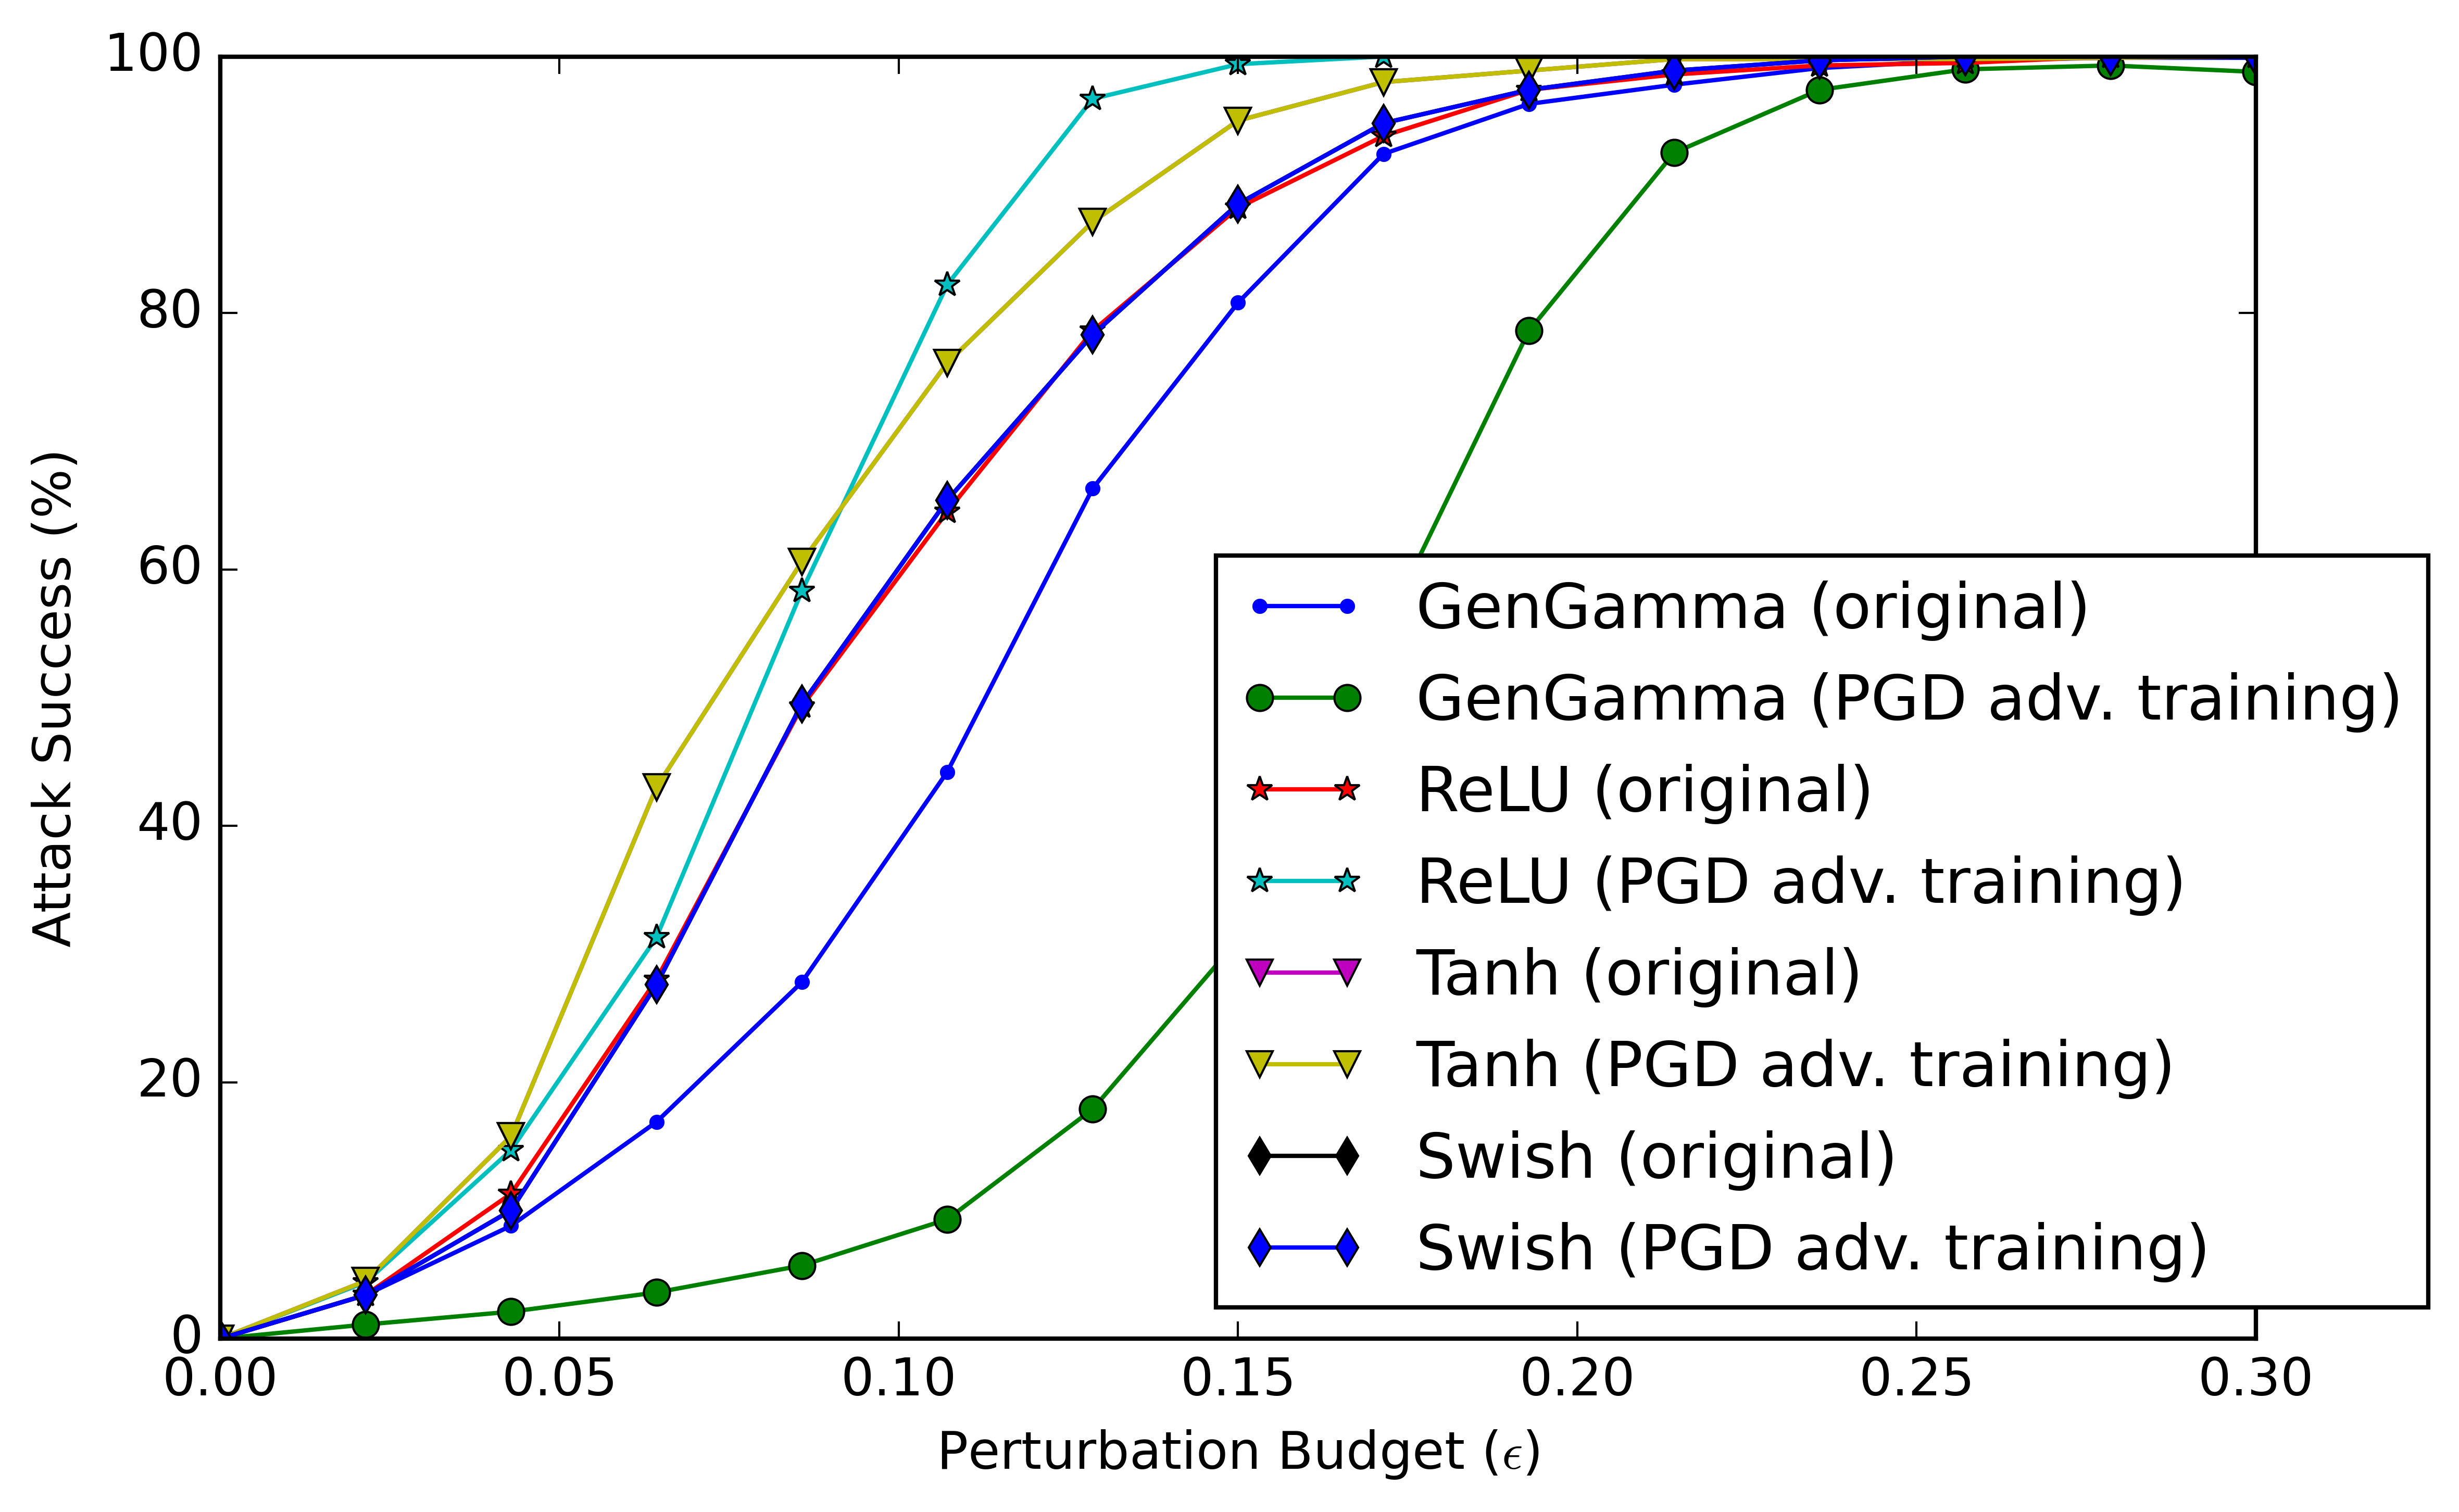

In [108]:
plt.figure(figsize=(8,5), dpi=600)

plt.plot(eps, attack_success(pgd_results_gengamma_original), label='GenGamma (original)', marker='.')
plt.plot(eps, attack_success(pgd_results_gengamma), label='GenGamma (PGD adv. training)', marker='o')

plt.plot(eps, attack_success(pgd_results_relu_original), label='ReLU (original)', marker='*')
plt.plot(eps, attack_success(pgd_results_relu), label='ReLU (PGD adv. training)', marker='*')

plt.plot(eps, attack_success(pgd_results_tanh_original), label='Tanh (original)', marker='v')
plt.plot(eps, attack_success(pgd_results_tanh), label='Tanh (PGD adv. training)', marker='v')

plt.plot(eps, attack_success(pgd_results_swish_original), label='Swish (original)', marker='d')
plt.plot(eps, attack_success(pgd_results_swish), label='Swish (PGD adv. training)', marker='d')

plt.legend(bbox_to_anchor=(1.1, 0), loc='lower right')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xlabel('Perturbation Budget ($\epsilon$)')
plt.ylabel('Attack Success (%)')
plt.tight_layout()
plt.savefig('images/adversarial_training_results_lenet_mnist_all.png', dpi=600)
plt.show()

## Adversarial Training with PGD under attack by FGSM?

In [83]:
fgsm_results_gengamma_advtraining = []
fgsm_results_gengamma_original = []

fgsm_results_relu = []
fgsm_results_tanh = []
fgsm_results_swish = []

eps = np.linspace(0, 0.5, 20)
for epsilon in eps:
    fgsm_results_gengamma_advtraining += [fgsm_attack(classifier_gengamma_new, eval_x_test_new, eval_y_test_new, eps=epsilon)]
    fgsm_results_relu += [fgsm_attack(classifier_relu_new, eval_x_test_relu_new, eval_y_test_relu_new, eps=epsilon)]
    fgsm_results_tanh += [fgsm_attack(classifier_tanh_new, eval_x_test_tanh_new, eval_y_test_tanh_new, eps=epsilon)]
    fgsm_results_swish += [fgsm_attack(classifier_swish_new, eval_x_test_swish_new, eval_y_test_swish_new, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.02631578947368421 done
eps 0.05263157894736842 done
eps 0.07894736842105263 done
eps 0.10526315789473684 done
eps 0.13157894736842105 done
eps 0.15789473684210525 done
eps 0.18421052631578946 done
eps 0.21052631578947367 done
eps 0.23684210526315788 done
eps 0.2631578947368421 done
eps 0.2894736842105263 done
eps 0.3157894736842105 done
eps 0.3421052631578947 done
eps 0.3684210526315789 done
eps 0.39473684210526316 done
eps 0.42105263157894735 done
eps 0.4473684210526315 done
eps 0.47368421052631576 done
eps 0.5 done


In [93]:
print(fgsm_results_gengamma_advtraining)
print(fgsm_results_relu)
print(fgsm_results_tanh)
print(fgsm_results_swish)

[100.0, 98.8, 97.3, 95.6, 93.4, 89.60000000000001, 82.6, 75.8, 63.1, 49.4, 40.400000000000006, 31.900000000000002, 24.8, 20.4, 16.900000000000002, 14.799999999999999, 13.0, 11.700000000000001, 10.5, 8.9]
[100.0, 93.7, 81.0, 59.199999999999996, 32.800000000000004, 11.700000000000001, 3.5999999999999996, 1.7000000000000002, 1.3, 1.0, 0.8999999999999999, 0.8, 0.5, 0.4, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3]
[100.0, 94.69999999999999, 79.5, 56.8, 37.3, 24.7, 16.6, 11.0, 7.000000000000001, 4.6, 2.8000000000000003, 1.7000000000000002, 1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.0, 0.0]
[100.0, 93.89999999999999, 77.4, 50.2, 21.8, 6.3, 1.7999999999999998, 1.0999999999999999, 0.7000000000000001, 0.5, 0.4, 0.4, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0]


In [94]:
## copied from the testing-on-mnist notebook results 
fgsm_results_gengamma_original = [100.0, 95.3, 88.1, 77.3, 64.2, 45.7, 28.4, 17.299999999999997, 12.1, 8.3, 5.8999999999999995, 4.2, 3.4000000000000004, 3.1, 2.4, 2.1999999999999997, 1.9, 1.7000000000000002, 1.4000000000000001, 1.4000000000000001]
fgsm_results_relu_original = [100.0, 95.7, 84.1, 62.0, 43.1, 29.9, 17.4, 9.1, 5.1, 2.6, 1.4000000000000001, 1.0999999999999999, 0.8999999999999999, 0.8, 0.8, 0.7000000000000001, 0.7000000000000001, 0.5, 0.5, 0.5]
fgsm_results_tanh_original = [100.0, 93.2, 79.60000000000001, 54.1, 37.5, 24.9, 16.3, 10.100000000000001, 6.4, 4.2, 2.4, 1.9, 1.3, 0.8999999999999999, 0.4, 0.3, 0.2, 0.1, 0.0, 0.0]
fgsm_results_swish_original = [100.0, 95.1, 84.7, 60.8, 42.199999999999996, 27.3, 15.2, 8.799999999999999, 4.6, 2.6, 1.6, 1.4000000000000001, 1.0, 0.8999999999999999, 0.8999999999999999, 0.8999999999999999, 0.8, 0.8, 0.7000000000000001, 0.6]

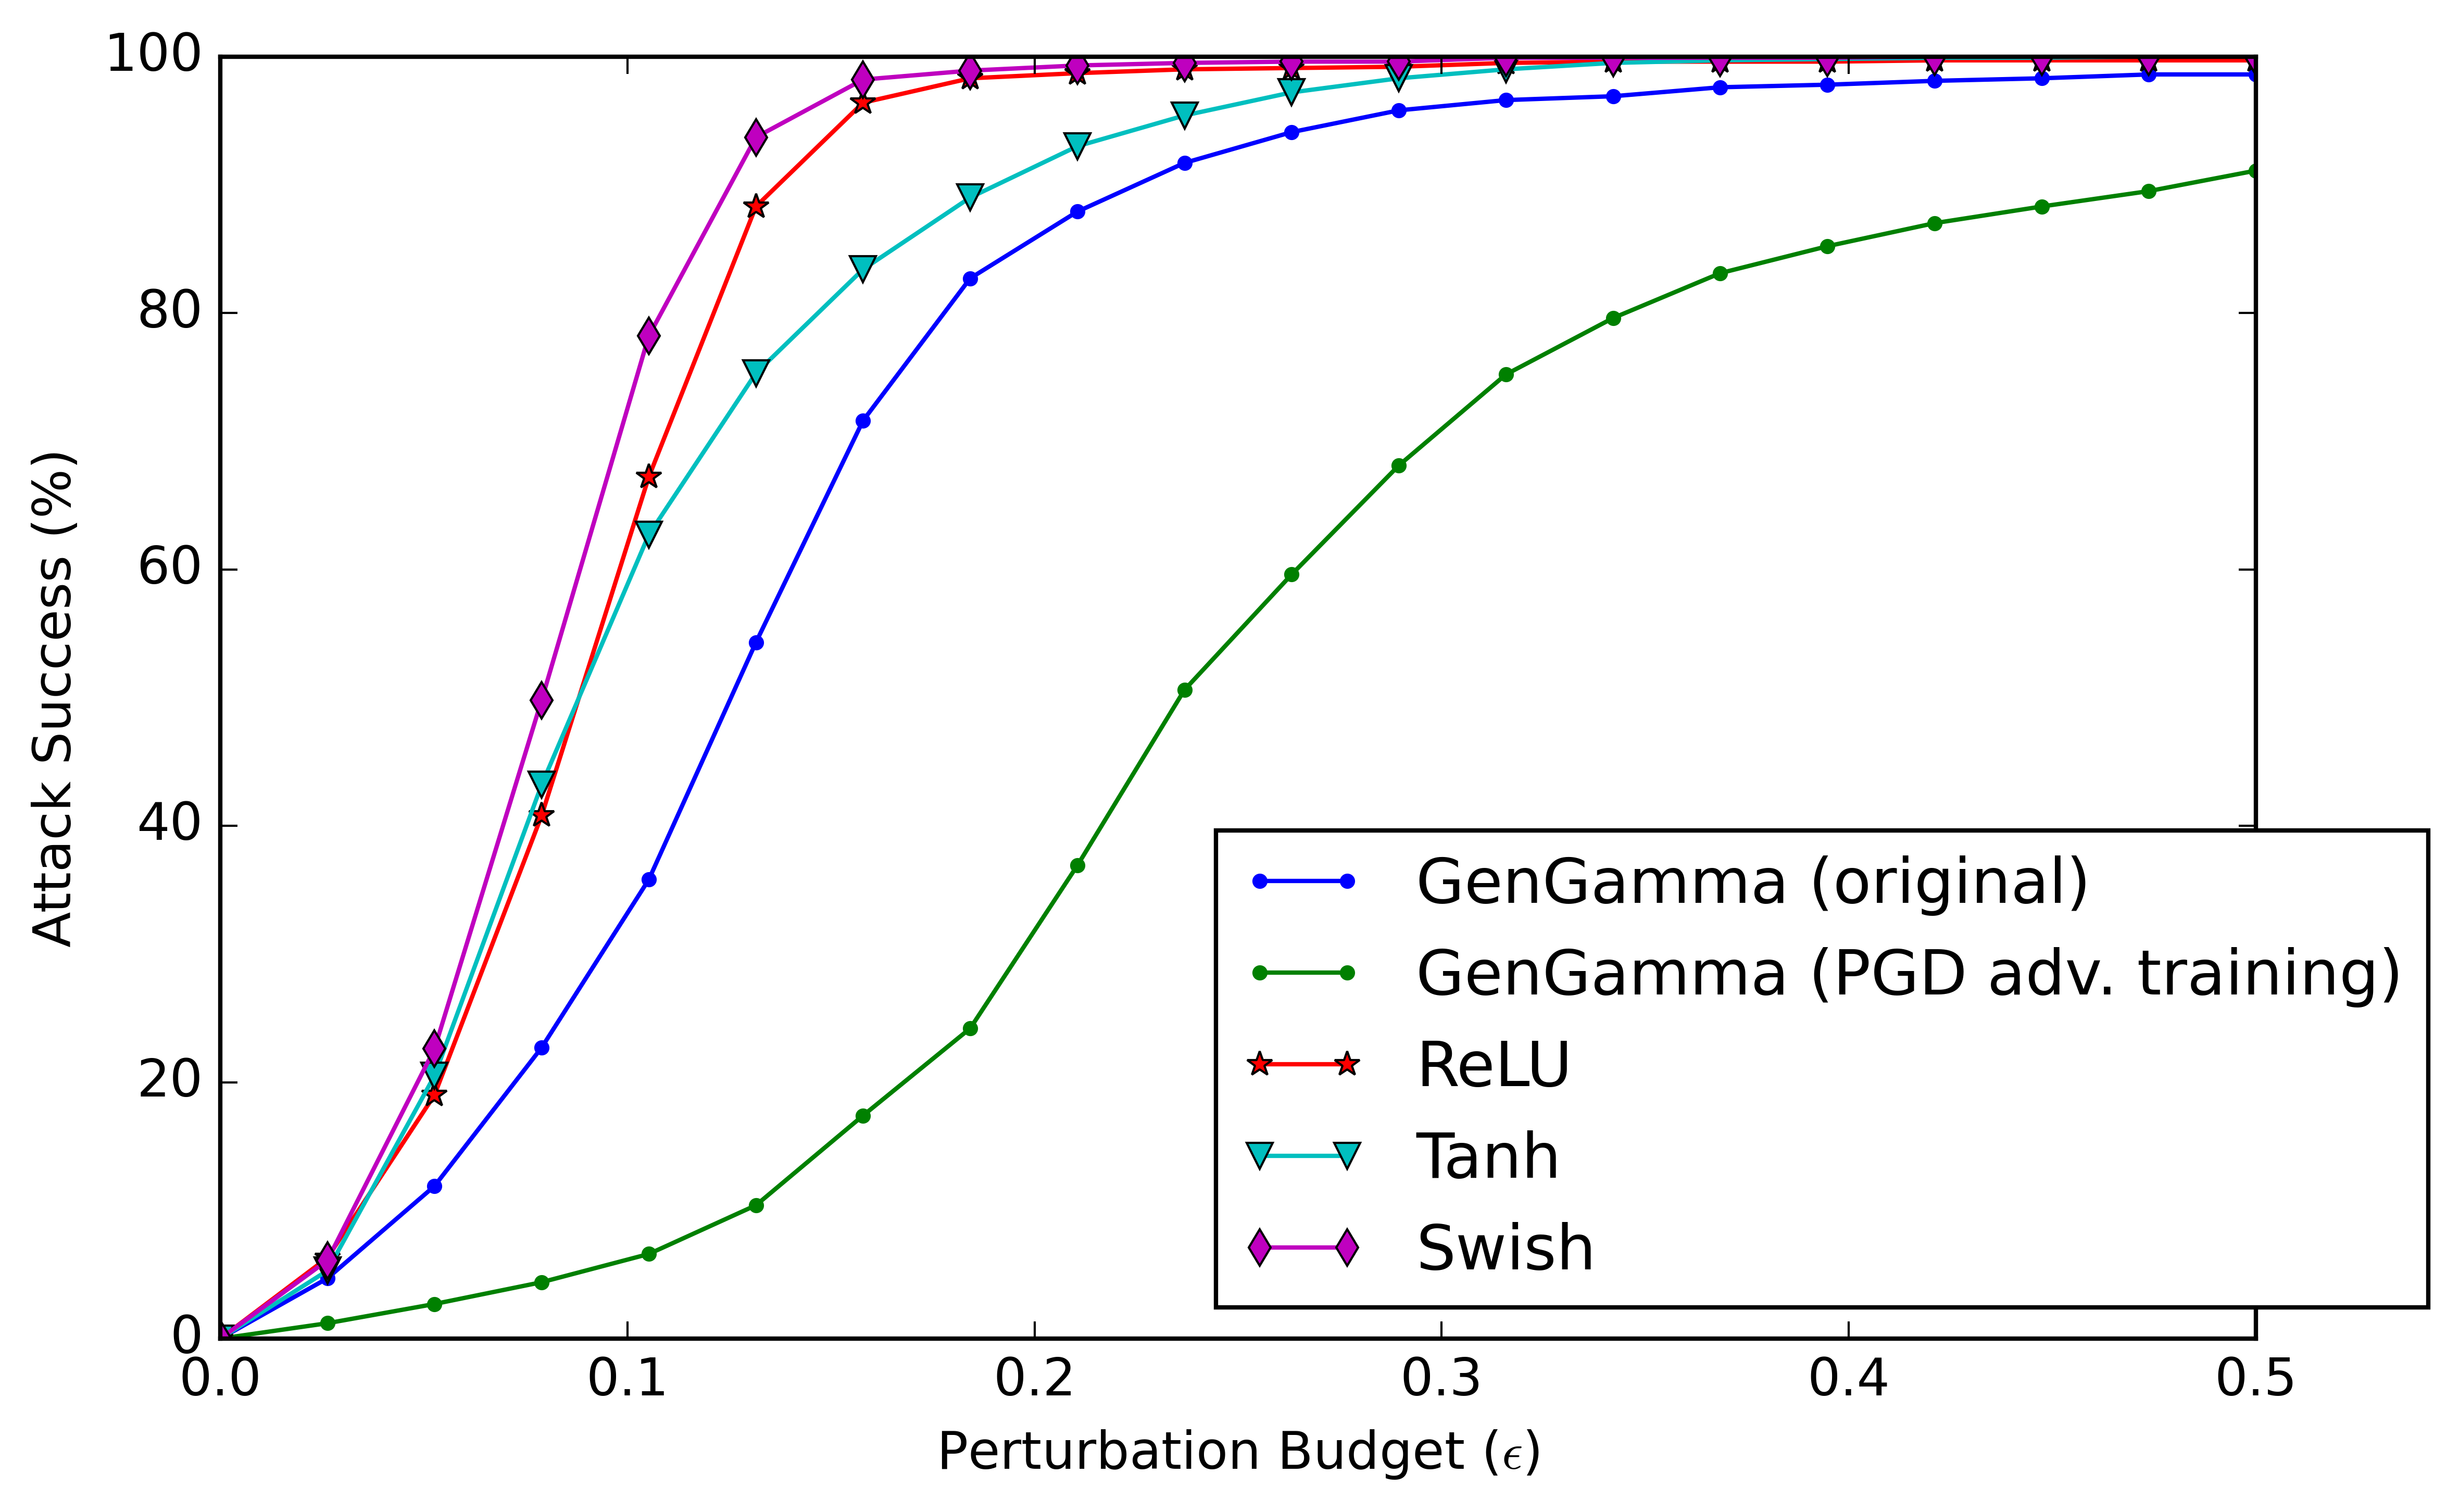

In [96]:
plt.figure(figsize=(8,5), dpi=600)
plt.plot(eps, attack_success(fgsm_results_gengamma_original), label='GenGamma (original)', marker='.')
plt.plot(eps, attack_success(fgsm_results_gengamma_advtraining), label='GenGamma (PGD adv. training)', marker='.')

# plt.plot(eps, attack_success(fgsm_results_relu_original), label='ReLU (original)', marker='*')
plt.plot(eps, attack_success(fgsm_results_relu), label='ReLU', marker='*')

# plt.plot(eps, attack_success(fgsm_results_tanh_original), label='Tanh (original)', marker='v')
plt.plot(eps, attack_success(fgsm_results_tanh), label='Tanh', marker='v')

# plt.plot(eps, attack_success(fgsm_results_swish_original), label='Swish (original)', marker='d')
plt.plot(eps, attack_success(fgsm_results_swish), label='Swish', marker='d')

plt.legend(bbox_to_anchor=(1.1, 0), loc='lower right')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xlabel('Perturbation Budget ($\epsilon$)')
plt.ylabel('Attack Success (%)')
plt.tight_layout()
plt.savefig('images/adversarial_training_pgd_fgsm_attack_lenet_mnist.png', dpi=600)
plt.show()